# Gradient  Guide Machine


[Gradient boost machine](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf) as an ensemble methhod takes the advantages fo functional gradient to boost the base/weak learner defined in the follwoing form:

$$F(x)=\sum_{m=1}^{M} f_m(x)$$
where $\{f_m(x)\mid m=1,2\dots, M\}$ are incremental  function to approximate the parrallel of  gradient $\frac{L(F(x), y)}{\partial F(x)}\mid_{F(x)=F_{i-1}(x)}$.
It is why we call it gradient boost machine.
It is obvious that there are more parameters of the final learner $F(x)$ as the number of base learner increase.

- https://stanfordmlgroup.github.io/projects/ngboost/
- https://web.stanford.edu/~hastie/TALKS/boost.pdf
- https://catboost.ai/

Simlar to gradient descent, the gradient is computed at each step.
Their differences are listed as following:

|Methods|Gradient Descent Method| Gradient Boost Machine
|:----|:----|:---
|Range|the parameter space $\mathbb{R}^p$| the functional space
|Update formula|$x_{t+1}=x_t-\alpha_{t}\nabla_{x} L(x_t)$| $F_{t+1}(x)=F_{t}(x)+\underbrace{f_t(x)}_{\text{approxmate to the parallel of the gradient}}$
|Final results|$x_{M}$ of a optimal model | $F_M(x)$ as an ensemble of base learner
|Step/shrinkage parameter|$\alpha_{t}\in\mathbb{R}$| Line search when fiiting the gradient
|Model Size| identitical to the dimension of parameter space $p$ | Proportional  to the numebr of base learner $\propto M$

The key idea behind gradient descent method is to find the parameter $x_{t+1}$ 
that makes the loss function $L(x)$ is smaller than the previous step, i.e., $L(x_{t+1})< L(x_t)$ where each step is to find a better model $F(x_{t+1})$. In fact, it can be rewriiten as $x_{t+1} =\arg\min_{x\in\operatorname{span}\{x_t, \nabla_x L(x_t) \} }L(x)$.

The key idea behind gradient boost machine is to learn from error $F_{\star}-F_{t}$ that makes the loss funtion descent, i.e., $ L(F_{\star}, F_{t}+f_{t}(x))< L(F^{\star}, F^{t})$.
It can be generalized to $f_{t}(x)=\arg\min_{f\in\mathcal F} L(F_{\star}, F_{t}+f)$.

## Gradient Guide Decision Tree

Gradient boost machine does not share the same iterative form with gradient descent methhod.
Based on gradient boost decision tree, we define a novel way to update decsion tree called as **gradient guide decision tree**.

______________
* Input training data set $\{(x_i, \mathrm{y}_i)\mid i=1, \cdots, n\}, x_i\in\mathcal x\subset\mathbb{R}^n, y_i\in\mathcal Y\subset\mathbb R$.
* Initialize $f_0(x)=\arg\min_{\gamma} L(\mathrm{y}_i,\gamma)$.
* For $t = 1, 2, \dots, T$:
   +   For $i = 1, 2,\dots , n$ compute
    $$r_{i,t}=f_{t-1}(x_i)-\alpha_{t}{[\frac{\partial L(\mathrm{y}_i, f(x_i))}{\partial f(x_i)}\mid_{f=f_{t-1}]}}.$$
   +  Fit a regression tree to the targets $r_{i,t}$   giving **terminal regions**
   $$R_{j,m}, j = 1, 2,\dots , J_m. $$
   +  For $j = 1, 2,\dots , J_m$ compute
      $$\gamma_{j,t}=\arg\min_{\gamma}\sum_{x_i\in R_{j,m}}{L(\mathrm{d}_i, f_{t-1}(x_i)+\gamma)}. $$
  +  Update $f_t = {\sum}_{j=1}^{J_m}{\gamma}_{j, t} \mathbb{I}(x\in R_{j, m})$.
* Output $f_T(x)$.

Here the step $\alpha_t\in\mathbb{R}$ paly the identical role as in gradient descent methods.

*****

The update formula is different from the gradient boost decision tree.
What is more, any gradient-based update formula can take the place of the foormula of targets $r_{i, t}$ such as [natural gradient boost](https://stanfordmlgroup.github.io/projects/ngboost/).

See this [blog](https://shivathudi.github.io/jekyll/update/2017/08/03/gbt-writeup.html) for more details and motivation of gradient boost decision tree. 

- https://stanfordmlgroup.github.io/projects/ngboost/

In fact, we can use any continous optimization methods to repalce the targets formula $\fbox{$f_{t-1}(x_i)-\alpha_{t}{[\frac{\partial L(\mathrm{y}_i, f(x_i))}{\partial f(x_i)}\mid _{f=f_{t-1}]}}$}$ such as the [ADMM boost](https://github.com/Hulalazz/A-_Guide_-to_Data_Sciecne_from_mathematics).

The following is the numerical experiemnts on this new methods and the classical boost methods such as xGBOost.

-- Gradient Boosting Regression --


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
Training: 100% [-----------------------------------------------] Time:  0:01:35


Mean Squared Error: 10.562952190897189


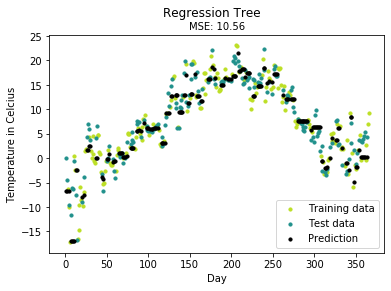

In [1]:
# %load I:/Machine-Learning-From-Scratch-master/gradient_boosting_decision_tree/gbd_regressor_example.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
%matplotlib inline
import sys

sys.path.append(r'G:/Machine-Learning-From-Scratch-master/')

from utils import train_test_split, standardize, to_categorical
from utils import mean_squared_error, accuracy_score, Plot
from utils.loss_functions import SquareLoss
from utils.misc import bar_widgets
from gradient_boosting_decision_tree.gbdt_model import GBDTRegressor


def main():
    print ("-- Gradient Boosting Regression --")

    # Load temperature data
    data = pd.read_csv('G:/Machine-Learning-From-Scratch-master/TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].as_matrix()).T
    temp = np.atleast_2d(data["temp"].as_matrix()).T

    X = time.reshape((-1, 1))               # Time. Fraction of the year [0, 1]
    X = np.insert(X, 0, values=1, axis=1)   # Insert bias term
    y = temp[:, 0]                          # Temperature. Reduce to one-dim

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    model = GBDTRegressor(learning_rate=0.03)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    mse = mean_squared_error(y_test, y_pred)

    print ("Mean Squared Error:", mse)

    # Plot the results
    m1 = plt.scatter(366 * X_train[:, 1], y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test[:, 1], y_test, color=cmap(0.5), s=10)
    m3 = plt.scatter(366 * X_test[:, 1], y_pred, color='black', s=10)
    plt.suptitle("Regression Tree")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2, m3), ("Training data", "Test data", "Prediction"), loc='lower right')
    plt.show()


if __name__ == "__main__":
    main()

-- Gradient Guide Regression --


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
Training: 100% [-----------------------------------------------] Time:  0:01:11


Mean Squared Error: 9.988787548891649


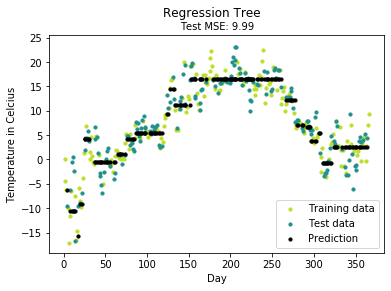

In [4]:
# %load I:/Machine-Learning-From-Scratch-master/gradient_guided_decision_tree/gg_example.py
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import progressbar

from utils import train_test_split, standardize, to_categorical
from utils import mean_squared_error, accuracy_score, Plot
from utils.loss_functions import SquareLoss
from utils.misc import bar_widgets
from gradient_guided_decision_tree.gg_model import GGuideDTRegressor

def main():
    print ("-- Gradient Guide Regression --")

    # Load temperature data
    data = pd.read_csv('G:/Machine-Learning-From-Scratch-master/TempLinkoping2016.txt',
           sep="\t")

    time = np.atleast_2d(data["time"].as_matrix()).T
    temp = np.atleast_2d(data["temp"].as_matrix()).T

    X = time.reshape((-1, 1))               # Time. Fraction of the year [0, 1]
    X = np.insert(X, 0, values=1, axis=1)   # Insert bias term
    y = temp[:, 0]                          # Temperature. Reduce to one-dim

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    model = GGuideDTRegressor(n_estimators=200,learning_rate=0.03)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    mse = mean_squared_error(y_test, y_pred)

    print ("Mean Squared Error:", mse)

    # Plot the results
    m1 = plt.scatter(366 * X_train[:, 1], y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test[:, 1], y_test, color=cmap(0.5), s=10)
    m3 = plt.scatter(366 * X_test[:, 1], y_pred, color='black', s=10)
    plt.suptitle("Regression Tree")
    plt.title("Test MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2, m3), ("Training data", "Test data", "Prediction"), loc='lower right')
    plt.show()


if __name__ == "__main__":
    main()


Test gradient guide decision tree in more data https://github.com/stanfordmlgroup/ngboost/tree/master/data.

- https://www.datacamp.com/community/tutorials/decision-tree-classification-python
- https://github.com/stanfordmlgroup/ngboost/tree/master/examples
- https://www.datacamp.com/community/tutorials/pandas-read-csv

We need more numerical experiment compared to boosted gradient decision tree.
The following paper give some referrence on the experiments.

- https://stanfordmlgroup.github.io/projects/ngboost/
- http://nicolas-hug.com/blog/around_gradient_boosting
- [Historical Gradient Boosting Machine](https://easychair.org/publications/open/pCtK)
- [Accelerated Gradient Boosting](https://arxiv.org/pdf/1803.02042.pdf)
- [Accelerating Gradient Boosting Machine](http://web.mit.edu/haihao/www/papers/AGBM.pdf)
- https://github.com/rahmacha/AdaBoost_M2_momentumNesterov

-- Gradient Guide Regression --
[1 1 2 0 1 0 2 0 0 0 1 2 2 1 2 1 2 1 1 2 0 2 2 2 1 2 0 1 1 2 1 2 1 2 2 1 1
 2 2 2 1 1 0 0 0 1 2 1 0 0 1 1 2 1 0 1 2 2 2 1 2 0 1 2 0 0 0 1 0 0 1 2 0 1
 1 0 0 2 1 1 1 1 1 0 0 1 2 0 2 2]


Training: 100% [-----------------------------------------------] Time:  0:00:26


Accuracy: 0.9833333333333333


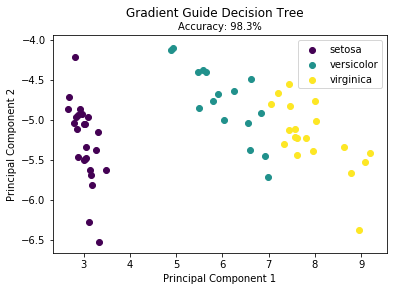

In [3]:
from sklearn import datasets
from gradient_guided_decision_tree.gg_model import GGDTClassifier
import sys

sys.path.append(r'G:/Machine-Learning-From-Scratch-master/')

def main():
    print ("-- Gradient Guide Regression --")

    # Load temperature data
    
    data = datasets.load_iris()
    X = data.data
    y = data.target

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
    print(y_train)

    model = GGDTClassifier(n_estimators=250,learning_rate=0.01)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    y_pred_line = model.predict(X)

    accuracy = accuracy_score(y_test, y_pred)

    print ("Accuracy:", accuracy)


    Plot().plot_in_2d(X_test, y_pred,
        title="Gradient Guide Decision Tree",
        accuracy=accuracy,
        legend_labels=data.target_names)


if __name__ == "__main__":
    main()

As the results shown, the GBDT is more random than gradient guide decision tree.
There are more ``line segment`` in gradient guide decision tree than gradient boost decision tree.
And gradient guide decision tree perform better than the gradient boost decision tree.

____
Gradient Guide Decision Tree | Gradient Boosting Decision Tree
:----|:----
Learn from the errors | To learn the residuals
$F_{(t+1)}\approx F_{(t)}-\nabla_{f} L(f)\mid_{f=F_{(t)}}$|$F_{(t+1)}= F_{(t)}+f_{t}$
`Fixed point` in fucntional /algorithematic space|`Taylor expansion` in fucntional /algorithematic space
Optimziation update formula in traget formula| Optimization procedure in update procedure
Parrallel to optimization methods | Analogous to optimization methods



This is the direct extention of gradient descent in functional space.
And this idea is easy to generalize to any continuous optimization methods such as gradient proximal methhods
by replacing the gradient of the update formula in the continuous optimiztaion methods.
We call such decision tree where the targets are replced by the update formula as `(profitable) iterative decision tree`.

It is a and definite  connection of continous optimization methods and boosting (ensemble) method in iterative schemes.





The basic idea of gradient boosting decision tree is to fit the residuals of the last tree.
In another word, residuals plays the role of dependent variables in gradient boosted decision tree.

The [following paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/1475-679X.12195) proves it is not always right.
However, gradient boosted decision tree replaces the residual with negative gradients.


- [Incorrect Inferences When Using Residuals as Dependent Variables](https://onlinelibrary.wiley.com/doi/abs/10.1111/1475-679X.12195)

Any techniques in continous optimization can be  applied to  decision tree such as the distributed optimization techniques, acceleration techniques, variance reduction techniques. It is really a brideg between continous optimization probelm and decision tree algorithm by replacing the targets with update formula in optimization methods.

Compared with boosted deciosin tree, iterative decision tree only stores the predicted values of the last tree not all the trained trees in history.
And gradient guide (iterative) decision tree does not ensemble many trees so that it is more efficient to predict on this tree traversal.

- https://www.idug.org/p/bl/et/blogaid=646


Note that in iterative decision tree, we do not modify the fitting methods of the decision tree. At each step ,we fit a tree with re-definded targets,
which makes the loss function decrease.
The terminal result of iterative decision tree is only one decision tree with lowwer cost.

## Theoretical concern: convergence and generalization 

Obviously, there is no room to improve when the functional gradient is 0s, i.e., $\nabla_{f} L(f)\mid_{f=F_{t}}=0$ like in gradient descent.
The theoretical concern is its convergence and generalization ability.
Like stochastic gradient descent, gradient guided decision tree does not perform the gradient descent exactly 
becasue the decision tree cannot fit the target $F_t-\alpha_t\nabla_{f} L(f)\mid_{f=F_t}$ without any error.
In this sense, it is similar to stochastic gradient descent.

- https://lizhongresearch.miraheze.org/wiki/Understanding_the_Power_of_Neural_Networks
- http://downloads.hindawi.com/journals/jece/2015/835357.pdf
- https://enesdilber.github.io/GiDL.pdf


See [A collection of research papers on decision, classification and regression trees with implementations.](https://github.com/benedekrozemberczki/awesome-decision-tree-papers) for more information on decisiontree .

###  Regularization of Iterative Decision Tree

`Decision Tree` is always considerd as non-parametric regresion method in statistics 
and step function in mathematical analysis(or simple function in measure theory).

In general, the cost function of supervised machine learn consists of two parts: 

* the sum of loss function of each sample $\sum_{n=1}^{N}\ell(f(x_n), y_n)$;
* the regularization term to control the model denoted as $\Omega(f)$.

Here $\Omega$ is a functional mapping the model $f$ to some nonnegative real number, i.e., 
$$\Omega:\mathcal{F}\mapsto \mathbb{R}^{+}$$
where $\mathcal F$ is the model space containing some types of functions.


- https://repository.upenn.edu/statistics_papers/370/
- http://rob-mcculloch.org/code/pbart.pdf
- https://astro.temple.edu/~msobel/
- http://www-stat.wharton.upenn.edu/~steele/
- http://rob-mcculloch.org/
- https://faculty.chicagobooth.edu/richard.hahn
- https://manduca.la.asu.edu/~prhahn/
- https://github.com/JakeColtman/bartpy
- https://jakecoltman.github.io/bartpy/
- https://faculty.chicagobooth.edu/veronika.rockova/

In iterative decision tree, the problem is how to compute the gradient of 
regularization terms with respect to the decision tree $\frac{\partial }{\partial f}\Omega(F)$.

What is more, the regularization term is not always differentiable.
The good news is that it is possible to compute these parts separately.

`Our problem is to find a new decision tree that fit a new targets and statisfy some constraints of the decision tree itself meanwhile.`
In mathematics, 

$$\arg\min_{f\in\mathcal{F}}L(f)(=\sum_{n=1}^{N}\ell(f(x_n), y_n)+\Omega(f))$$

Alternate mnimization: (1) fit a tree with the targets $f_{t}(x_n)-\alpha_t\{\nabla_{f(x)} \ell(f(x_n), y_n)\mid_{f(x)=f_{t}(x_n)}\}$ and output the new tree $f_{t}$;
(2) minimize the regularization term $\Omega(f)$ as post-pruning.

Like xGBoost, we can fit a optimal values of $\sum_{n=1}^{N}\ell(f(x_n)+x, y_n)+\Omega(f)$.

- http://datascience.la/xgboost-workshop-and-meetup-talk-with-tianqi-chen/
- http://dmlc.cs.washington.edu/data/pdf/XGBoostArxiv.pdf